In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [5]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest
# the following (used in Figure S16) require
# R to be installed along with R packages `lme4` and `lmerTest`
from pymer4.models import Lmer
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
lme4 = importr('lme4')

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, stats, plot
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

Load the simulation data that was curated in Figure 2:

In [6]:
parcels = transform.load_ordered_parcel_labels('schaefer-100')
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")

best_runs = subjects_optima.groupby('sub')['gof'].idxmax().values
data = subjects_optima.loc[best_runs].set_index('sub')
data[['age', 'sex','group']] = elig_subs.loc[data.index,['age', 'sex','group']]
data['Age (y)'] = data['age'] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)

# Figure S16. Association of $r^E$, $I^E$ and $\frac{S^E}{S^I}$ time series in the optimal simulation of an example subject

Randomly select a subject and re-run its simulation while saving the time series of model state variables:

In [7]:
np.random.seed(0)
sub = np.random.choice(data.index, 1)[0]
SeedMW = data.loc[sub, 'SeedMW']
print(sub, SeedMW)

sub-609135444969 1


In [ ]:
!python run_sim.py $sub $SeedMW

Load simulation data:

In [8]:
sim_data = np.load(
    os.path.join(
        os.environ["PNC_PROJECT_DIR"], "output",
        "sim", sub,
        "ctx_parc-schaefer-100_mean001_thresh-1",
        "6maps_schaefer-100_zscore", "cmaes_multimaps_gpu",
        f"ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_het-wee-wei_SeedMW-{SeedMW}_SeedSim-410_n-81x210_cubnm",
        "ts", "it1.npz",
    ),
    allow_pickle=True,
)

## a. Time series of 3 randomly selected nodes

44 PearsonRResult(statistic=0.30922568416198504, pvalue=0.00020117048759187332) PearsonRResult(statistic=0.922539996978152, pvalue=6.301400076611038e-59)
47 PearsonRResult(statistic=0.5106177879963912, pvalue=1.153756112972119e-10) PearsonRResult(statistic=0.9246639631243744, pvalue=9.962895173612791e-60)
64 PearsonRResult(statistic=0.45180744451690397, pvalue=2.1038215498701294e-08) PearsonRResult(statistic=0.9596508121963081, pvalue=6.482840271135489e-78)


Text(0.5, 0, 'Simulation time')

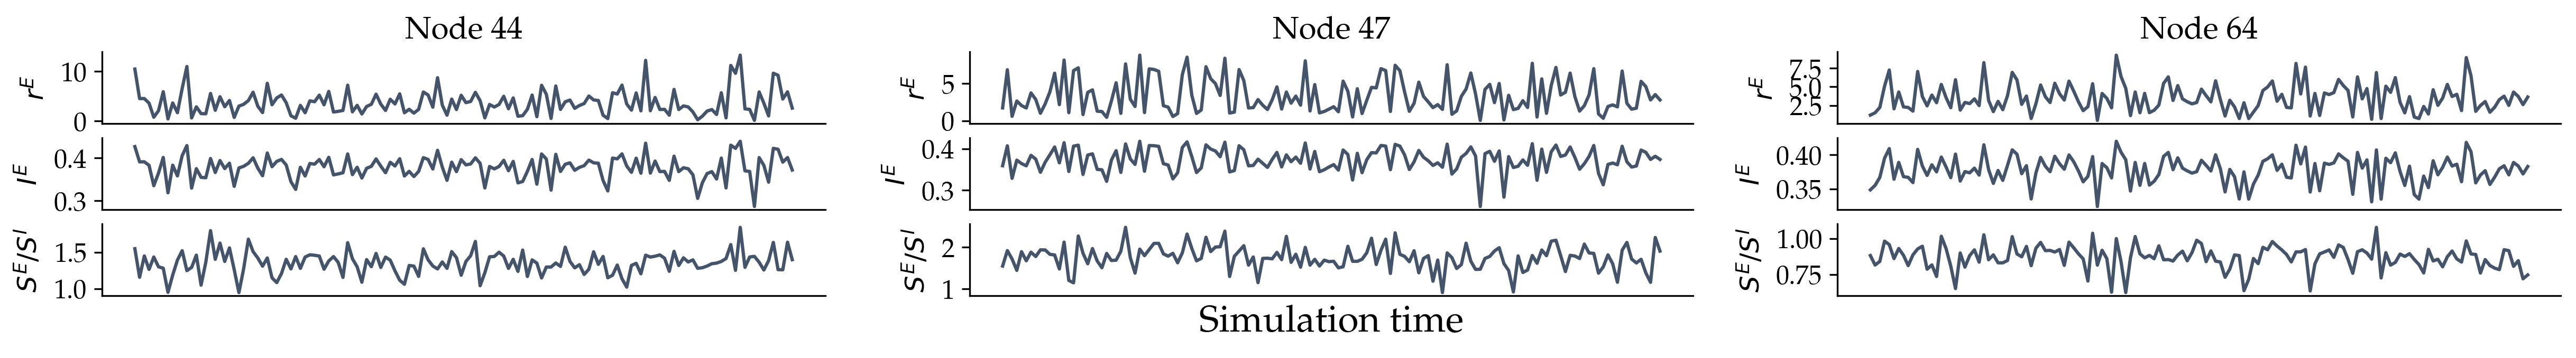

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(20, 2))

clean_labels = {
    'r_E': r'$r^E$',
    'I_E': r'$I^E$',
    'S_ratio': r'$S^E/S^I$',
}

np.random.seed(0)

for j, node in enumerate(np.random.choice(100, 3)):
    ts = {}
    ts['I_E'] = sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:, node]
    ts['r_E'] = sim_data["sim_states"].reshape(1)[0]["r_E"][0, 10:, node]
    ts['S_E'] = sim_data["sim_states"].reshape(1)[0]["S_E"][0, 10:, node]
    ts['S_I'] = sim_data["sim_states"].reshape(1)[0]["S_I"][0, 10:, node]
    ts['S_ratio'] = ts['S_E'] / ts['S_I']
    ts_d = pd.DataFrame(ts)
    axes[0, j].set_title(f'Node {node}')
    for i, k in enumerate(['r_E', 'I_E', 'S_ratio']):
        axes[i,j].plot(ts_d[k], color=thcolor)
        axes[i,j].set_ylabel(clean_labels[k])
        if i < len(ts)-1:
            axes[i,j].set_xticks([])
        sns.despine()
    print(node, scipy.stats.pearsonr(ts['S_ratio'], ts['r_E']),scipy.stats.pearsonr(ts['I_E'], ts['r_E']))
axes[2,1].set_xlabel('Simulation time', fontsize=17)

## b. Associations of model states across nodes and time

### Fit models

In [10]:
long_df = pd.DataFrame({
    'r_E': sim_data["sim_states"].reshape(1)[0]["r_E"][0, 10:].T.flatten(),
    'I_E': sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:].T.flatten(),
    'S_ratio': (
            sim_data["sim_states"].reshape(1)[0]["S_E"][0, 10:] / 
            sim_data["sim_states"].reshape(1)[0]["S_I"][0, 10:]
        ).T.flatten(),
    'time': np.tile(np.arange(140), 100),
    'node': np.repeat(np.arange(100), 140)
})

# exclude upper 2.5% of S_ratio (including values approaching inf)
long_df = long_df.loc[long_df['S_ratio']<long_df['S_ratio'].quantile(0.975)]

# copy to R
long_df_r = pandas2ri.py2rpy(long_df)

In [11]:
residuals = {
    'Linear': {},
    'Log': {}
}

r2s = {
    'Linear': {},
    'Log': {}
}

AICs = {
    'Linear': {},
    'Log': {}
}

#### Linear

Using `pymer4`

$r^E$ ~ $I^E$

In [12]:
model = Lmer("r_E ~ I_E + (1 + I_E | node)", data=long_df)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: r_E~I_E+(1+I_E|node)

Family: gaussian	 Inference: parametric

Number of observations: 13650	 Groups: {'node': 100.0}

Log-likelihood: -27386.889 	 AIC: 54785.779

Random effects:

                 Name      Var     Std
node      (Intercept)   22.923   4.788
node              I_E  187.530  13.694
Residual                 3.113   1.764

              IV1  IV2  Corr
node  (Intercept)  I_E -0.99

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   -32.094 -33.102  -31.086  0.514  93.649 -62.415    0.0  ***
I_E            96.380  93.523   99.236  1.457  90.848  66.128    0.0  ***


In [13]:
r2 = 1 - (((model.residuals)**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.8253053694862407

In [14]:
residuals['Linear']['r_E~I_E'] = model.residuals
r2s['Linear']['r_E~I_E'] = r2
AICs['Linear']['r_E~I_E'] = model.AIC

$r^E$ ~ $\frac{S^E}{S^I}$

In [15]:
model = Lmer("r_E ~ S_ratio + (1 + S_ratio | node)", data=long_df)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: r_E~S_ratio+(1+S_ratio|node)

Family: gaussian	 Inference: parametric

Number of observations: 13650	 Groups: {'node': 100.0}

Log-likelihood: -34730.806 	 AIC: 69473.612

Random effects:

                 Name     Var    Std
node      (Intercept)  49.530  7.038
node          S_ratio  15.123  3.889
Residual                8.895  2.983

              IV1      IV2   Corr
node  (Intercept)  S_ratio -0.472

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)   -12.008 -13.448  -10.568  0.735  100.431 -16.344    0.0  ***
S_ratio         9.325   8.503   10.147  0.419   93.884  22.235    0.0  ***


In [16]:
r2 = 1 - (((model.residuals)**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.5009826793361782

In [17]:
residuals['Linear']['r_E~S_ratio'] = model.residuals
r2s['Linear']['r_E~S_ratio'] = r2
AICs['Linear']['r_E~S_ratio'] = model.AIC

$I^E$ ~ $\frac{S^E}{S^I}$

In [18]:
model = Lmer("I_E ~ S_ratio + (1 + S_ratio | node)", data=long_df)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: I_E~S_ratio+(1+S_ratio|node)

Family: gaussian	 Inference: parametric

Number of observations: 13650	 Groups: {'node': 100.0}

Log-likelihood: 29647.764 	 AIC: -59283.528

Random effects:

                 Name    Var    Std
node      (Intercept)  0.004  0.062
node          S_ratio  0.001  0.033
Residual               0.001  0.027

              IV1      IV2   Corr
node  (Intercept)  S_ratio -0.272

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.228   0.215    0.240  0.006  100.634  35.101    0.0  ***
S_ratio         0.085   0.078    0.093  0.004   88.931  23.682    0.0  ***


In [19]:
r2 = 1 - (((model.residuals)**2).sum()) / (((long_df['I_E']-long_df['I_E'].mean())**2).sum())
r2

0.46921864133186175

In [20]:
residuals['Linear']['I_E~S_ratio'] = model.residuals
r2s['Linear']['I_E~S_ratio'] = r2
AICs['Linear']['I_E~S_ratio'] = model.AIC

#### With logarithmic linking

This is not supported in `pymer4`, therefore it will be done directly using R via `rpy2` interface and usign `lme4` package.

$r^E$ ~ $I^E$

In [21]:
%%time
model = lme4.glmer("r_E ~ I_E + (1 + I_E | node)", data=long_df_r, family=robjects.r.gaussian(link = "log"), verbose=False)
# suppress the printing of data in summary
model.do_slot_assign('call', None)
print(robjects.r.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: gaussian  ( log )

     AIC      BIC   logLik deviance df.resid 
 27239.7  27284.8 -13613.8  27227.7    13644 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-17.7962  -0.6325  -0.2421   0.2570   5.7773 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 node     (Intercept) 0.7665   0.8755        
          I_E         4.5650   2.1366   -1.00
 Residual             0.4194   0.6476        
Number of obs: 13650, groups:  node, 100

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  -7.4163     0.1348  -55.02   <2e-16 ***
I_E          22.8385     0.3291   69.40   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
I_E -1.000
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00224405 (tol = 0.002, component 1)


CPU ti

In [22]:
residual = pd.Series(robjects.r.residuals(model, type="response"), index=long_df.index)

In [23]:
r2 = 1 - ((residual**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.9766943363070038

In [24]:
residuals['Log']['r_E~I_E'] = residual
r2s['Log']['r_E~I_E'] = r2
AICs['Log']['r_E~I_E'] = robjects.r.AIC(model)[0]

$r^E$ ~ $\frac{S^E}{S^I}$

In [25]:
%%time
model = lme4.glmer("r_E ~ S_ratio + (1 + S_ratio | node)", data=long_df_r, family=robjects.r.gaussian(link = "log"), verbose=False)
# suppress the printing of data in summary
model.do_slot_assign('call', None)
print(robjects.r.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: gaussian  ( log )

     AIC      BIC   logLik deviance df.resid 
 67770.2  67815.3 -33879.1  67758.2    13644 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3971 -0.6372 -0.1944  0.4206  8.7321 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 node     (Intercept)  7.896   2.810         
          S_ratio     14.624   3.824    -0.74
 Residual              7.523   2.743         
Number of obs: 13650, groups:  node, 100

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  -2.5730     0.1066  -24.14   <2e-16 ***
S_ratio       2.5354     0.1412   17.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
S_ratio -0.741

CPU times: user 1.74 s, sys: 783 µs, total: 1.74 s
Wall time: 1.76 s


In [26]:
residual = pd.Series(robjects.r.residuals(model, type="response"), index=long_df.index)

In [27]:
r2 = 1 - ((residual**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.5730655801933096

In [28]:
residuals['Log']['r_E~S_ratio'] = residual
r2s['Log']['r_E~S_ratio'] = r2
AICs['Log']['r_E~S_ratio'] = robjects.r.AIC(model)[0]

$I^E$ ~ $\frac{S^E}{S^I}$

In [29]:
%%time
model = lme4.glmer("I_E ~ S_ratio + (1 + S_ratio | node)", data=long_df_r, family=robjects.r.gaussian(link = "log"), verbose=False)
# suppress the printing of data in summary
model.do_slot_assign('call', None)
print(robjects.r.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: gaussian  ( log )

     AIC      BIC   logLik deviance df.resid 
-59743.3 -59698.2  29877.6 -59755.3    13644 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6948 -0.5708  0.0419  0.6178  4.6662 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 node     (Intercept) 0.0075471 0.08687       
          S_ratio     0.0025010 0.05001  -0.68
 Residual             0.0007564 0.02750       
Number of obs: 13650, groups:  node, 100

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept) -1.49955    0.03176  -47.22   <2e-16 ***
S_ratio      0.27846    0.01676   16.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
S_ratio -0.313

CPU times: user 4.94 s, sys: 1.9 ms, total: 4.94 s
Wall time: 4.99 s


In [30]:
residual = pd.Series(robjects.r.residuals(model, type="response"), index=long_df.index)

In [31]:
r2 = 1 - ((residual**2).sum()) / (((long_df['I_E']-long_df['I_E'].mean())**2).sum())
r2

0.4686750914615274

In [32]:
residuals['Log']['I_E~S_ratio'] = residual
r2s['Log']['I_E~S_ratio'] = r2
AICs['Log']['I_E~S_ratio'] = robjects.r.AIC(model)[0]

### Plot best models

In [33]:
pd.DataFrame(AICs).T.idxmin()

r_E~I_E        Log
r_E~S_ratio    Log
I_E~S_ratio    Log
dtype: object

It's the log model in all associations

#### $r^E$ ~ $I^E$

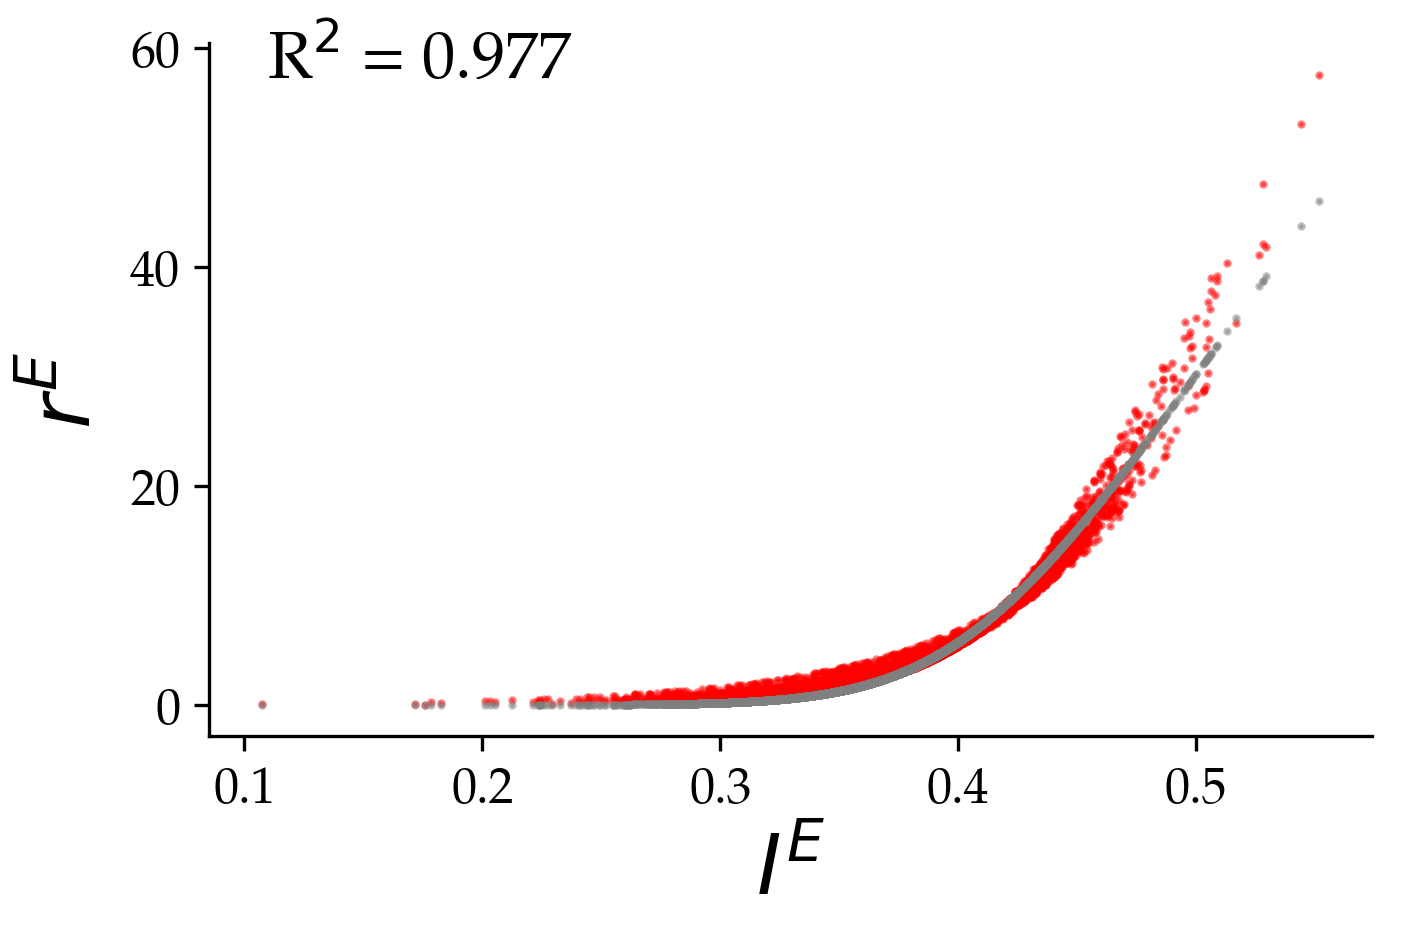

In [34]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(long_df['I_E'], long_df['r_E']-residuals['Log']['r_E~I_E'], s=1, color='red', alpha=0.5)
ax.scatter(long_df['I_E'], long_df['r_E'], s=1, color='grey', alpha=0.5)
ax.set_xlabel(r'$I^E$', fontsize=20)
ax.set_ylabel(r'$r^E$', fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
ax.text(text_x, text_y, r'R$^2$ = 'f'{r2s["Log"]["r_E~I_E"]:.3f}', color="black", size=16, multialignment="left")
sns.despine()

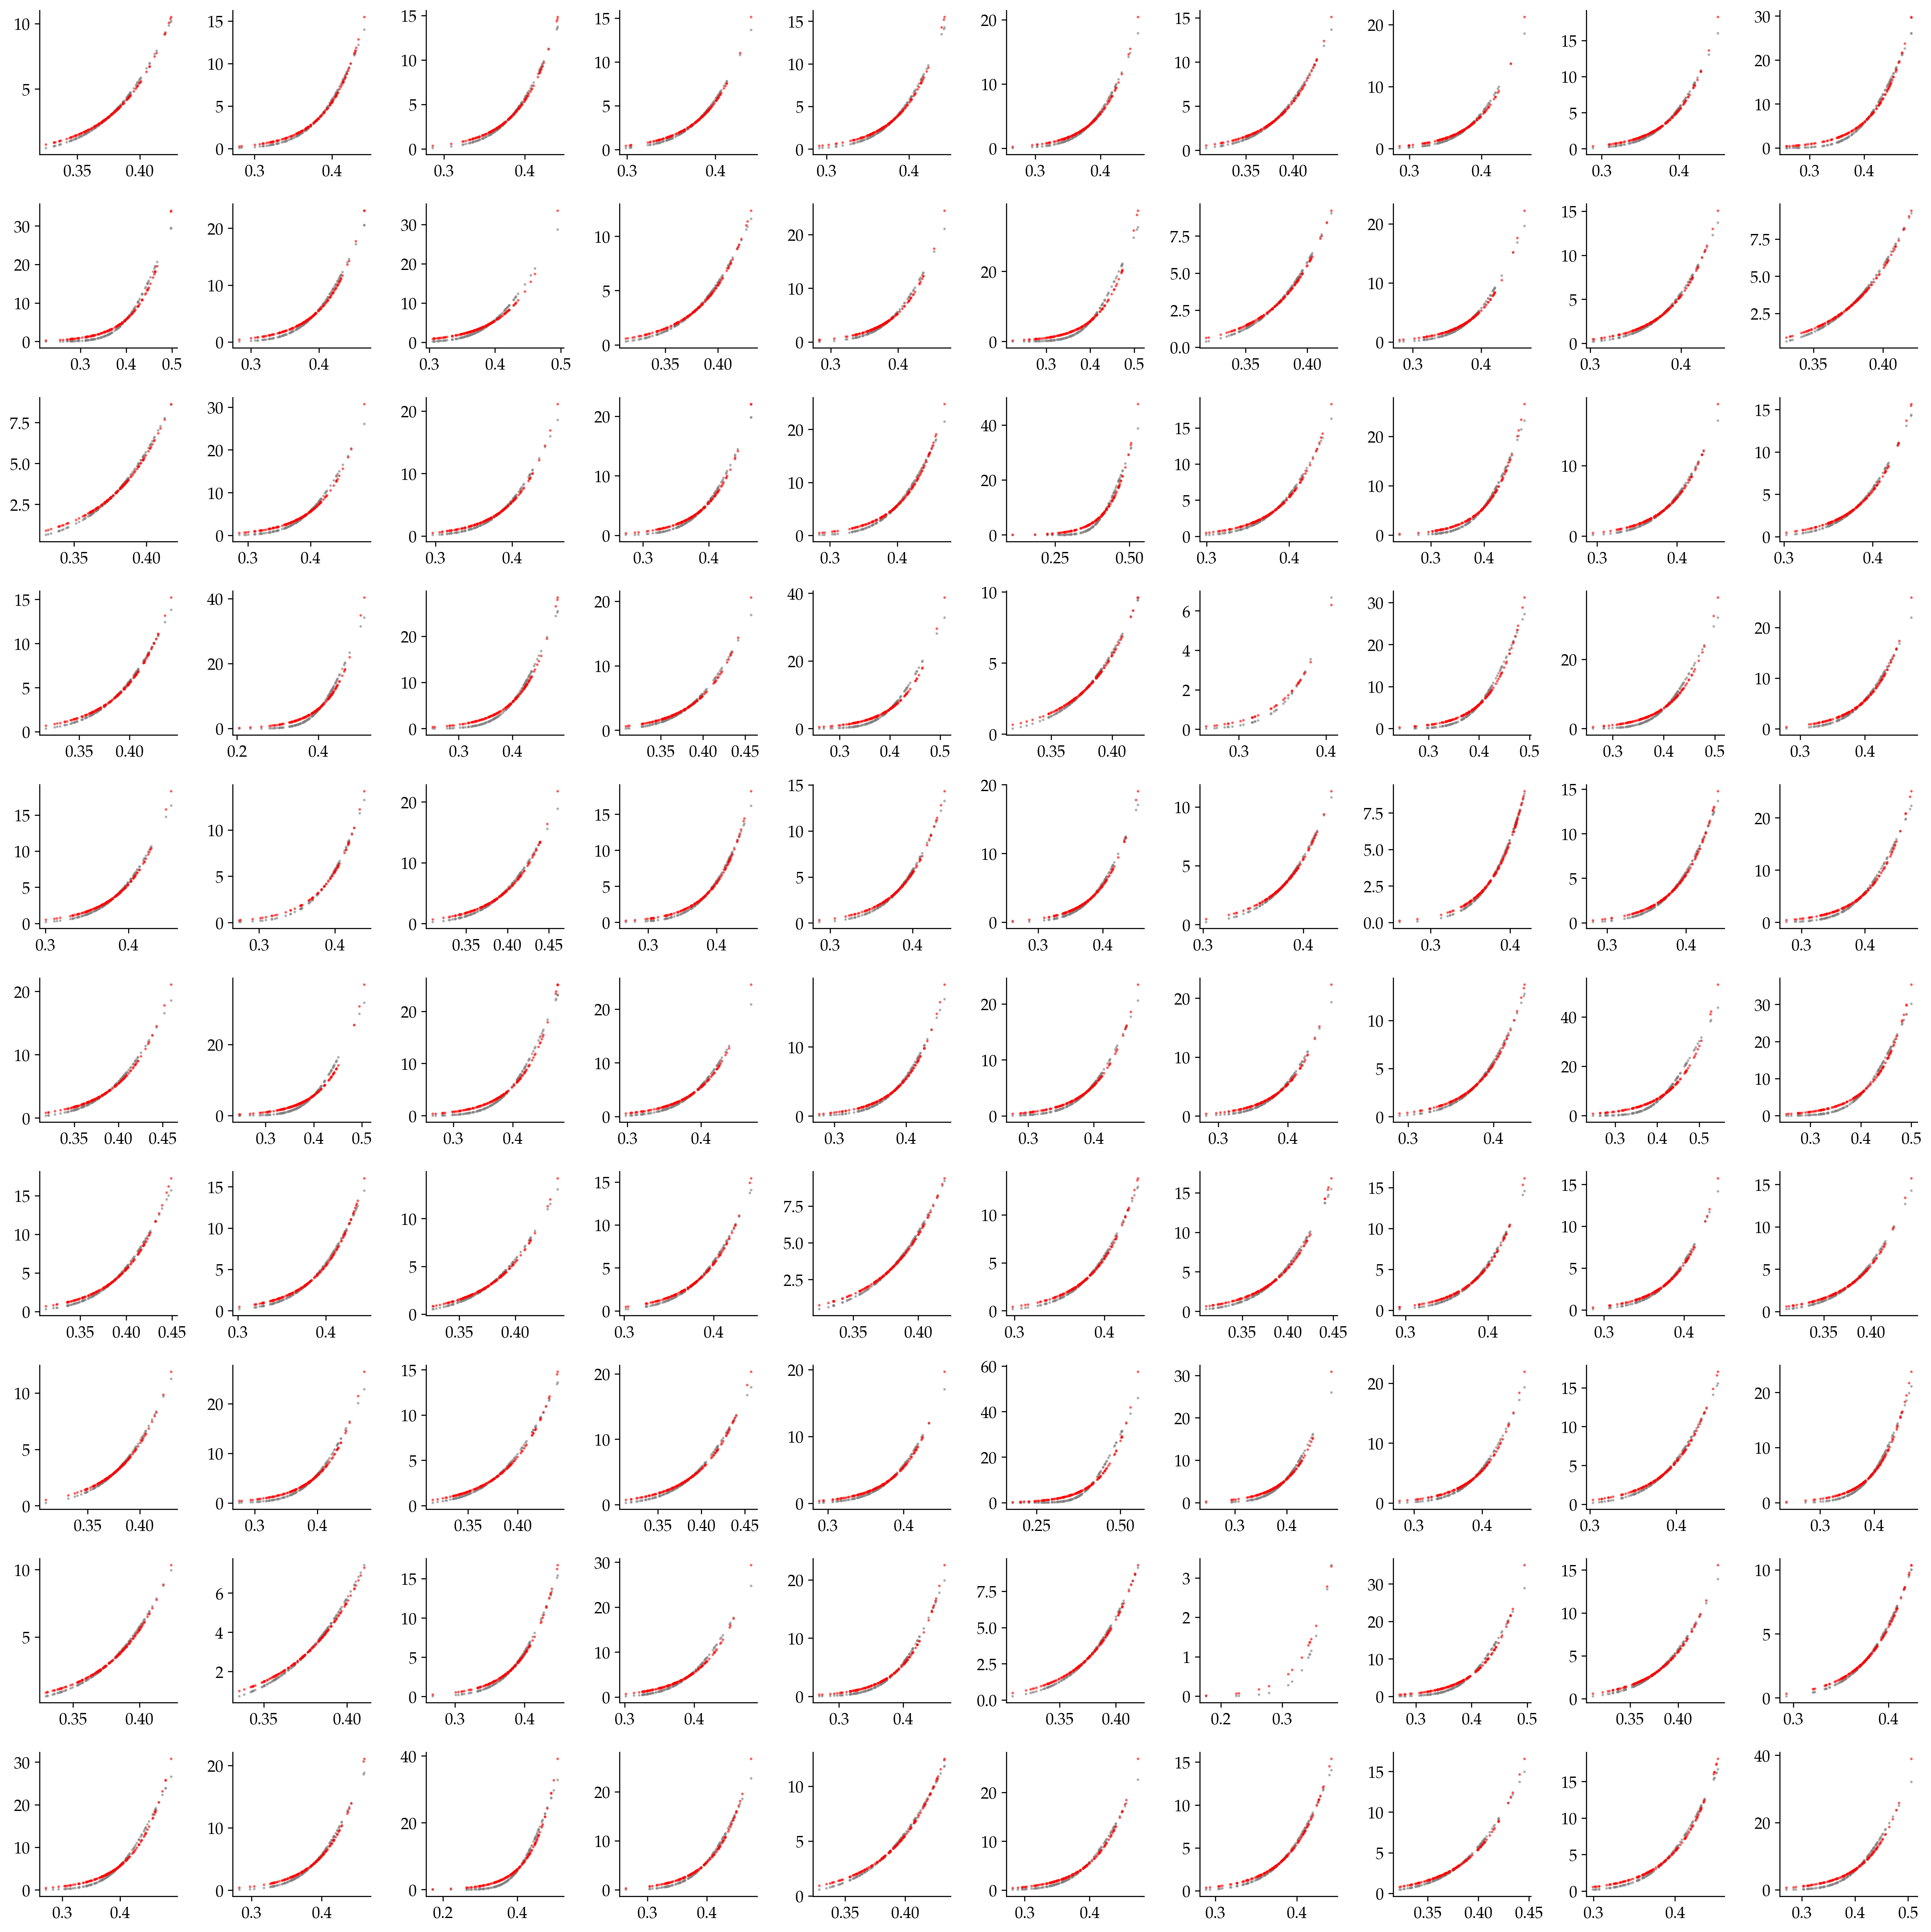

In [35]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for node, node_df in long_df.groupby('node'):
    ax = axes[node]
    ax.scatter(node_df['I_E'], node_df['r_E'], s=1, color='grey', alpha=0.5)
    ax.scatter(node_df['I_E'], node_df['r_E']-residuals['Log']['r_E~I_E'].loc[node_df.index], s=1, color='red', alpha=0.5)
    sns.despine()
fig.tight_layout()

(0.0, 1.0, 0.0, 1.0)

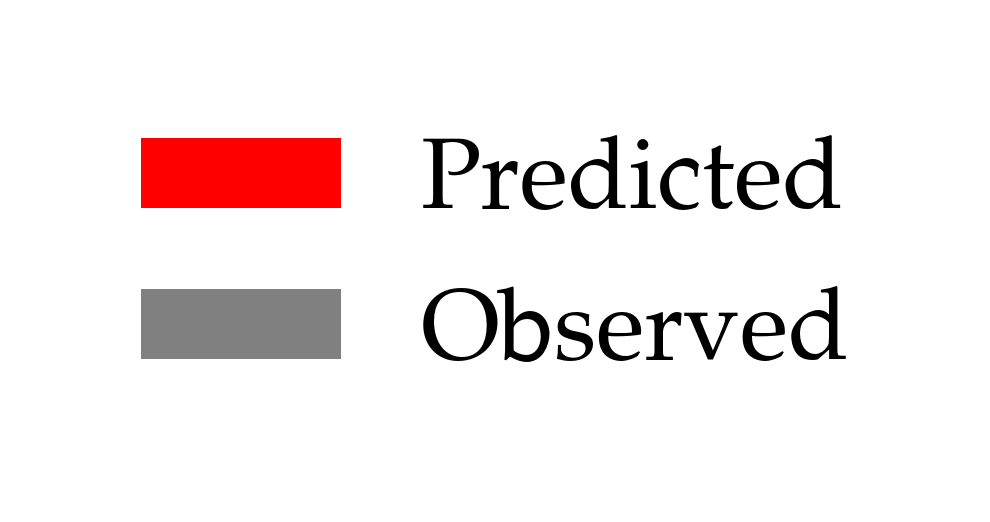

In [36]:
from matplotlib.patches import Patch
colors = {"Predicted": 'red', "Observed": 'grey'}
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")

#### $r^E$ ~ $\frac{S^E}{S^I}$

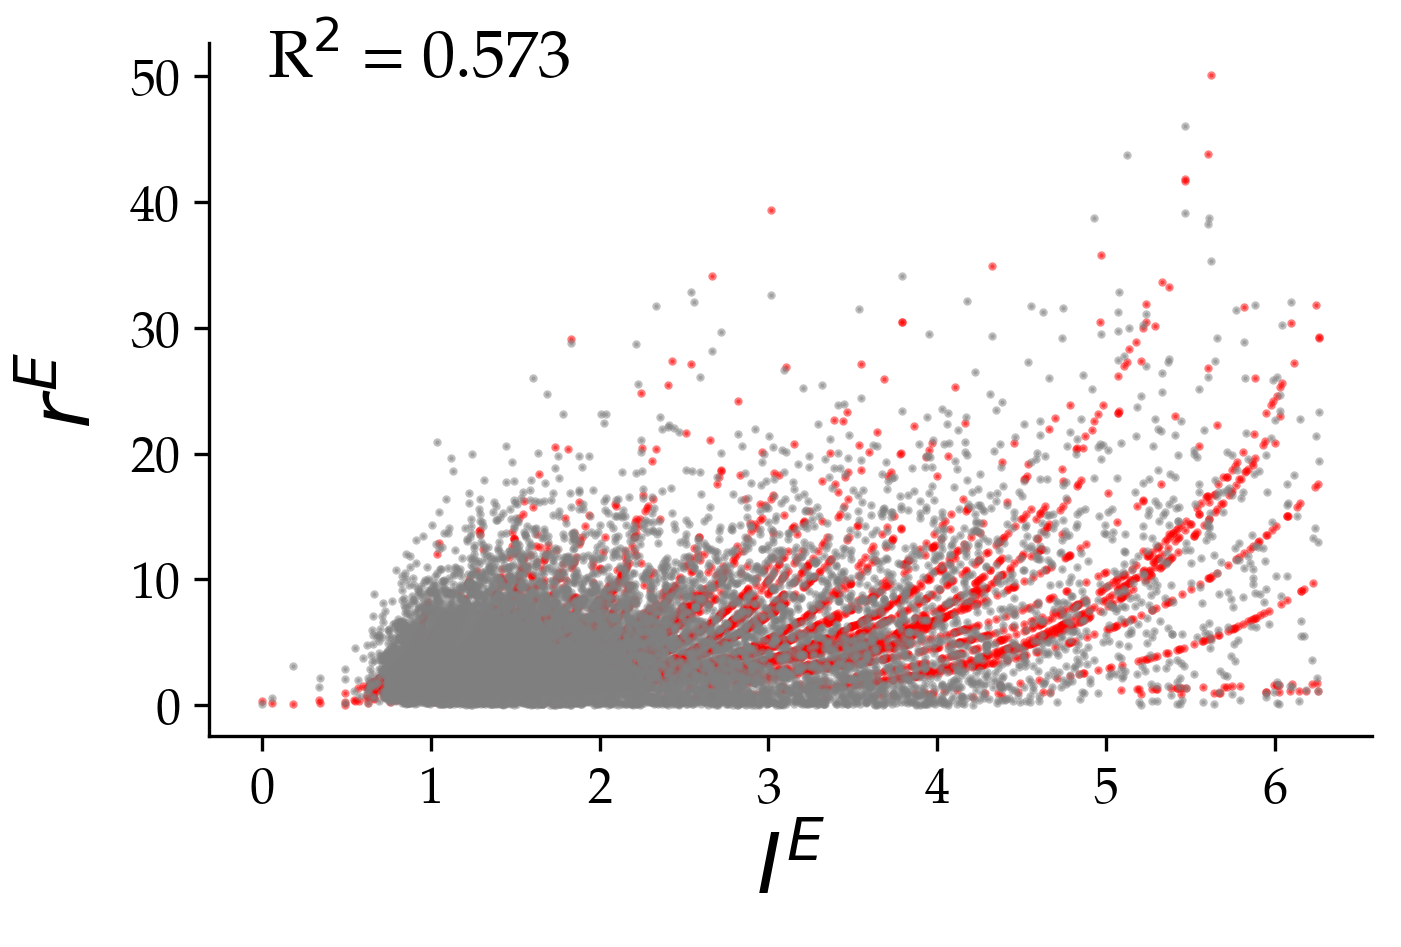

In [37]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(long_df['S_ratio'], long_df['r_E']-residuals['Log']['r_E~S_ratio'], s=1, color='red', alpha=0.5)
ax.scatter(long_df['S_ratio'], long_df['r_E'], s=1, color='grey', alpha=0.5)
ax.set_xlabel(r'$I^E$', fontsize=20)
ax.set_ylabel(r'$r^E$', fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
ax.text(text_x, text_y, r'R$^2$ = 'f'{r2s["Log"]["r_E~S_ratio"]:.3f}', color="black", size=16, multialignment="left")
sns.despine()

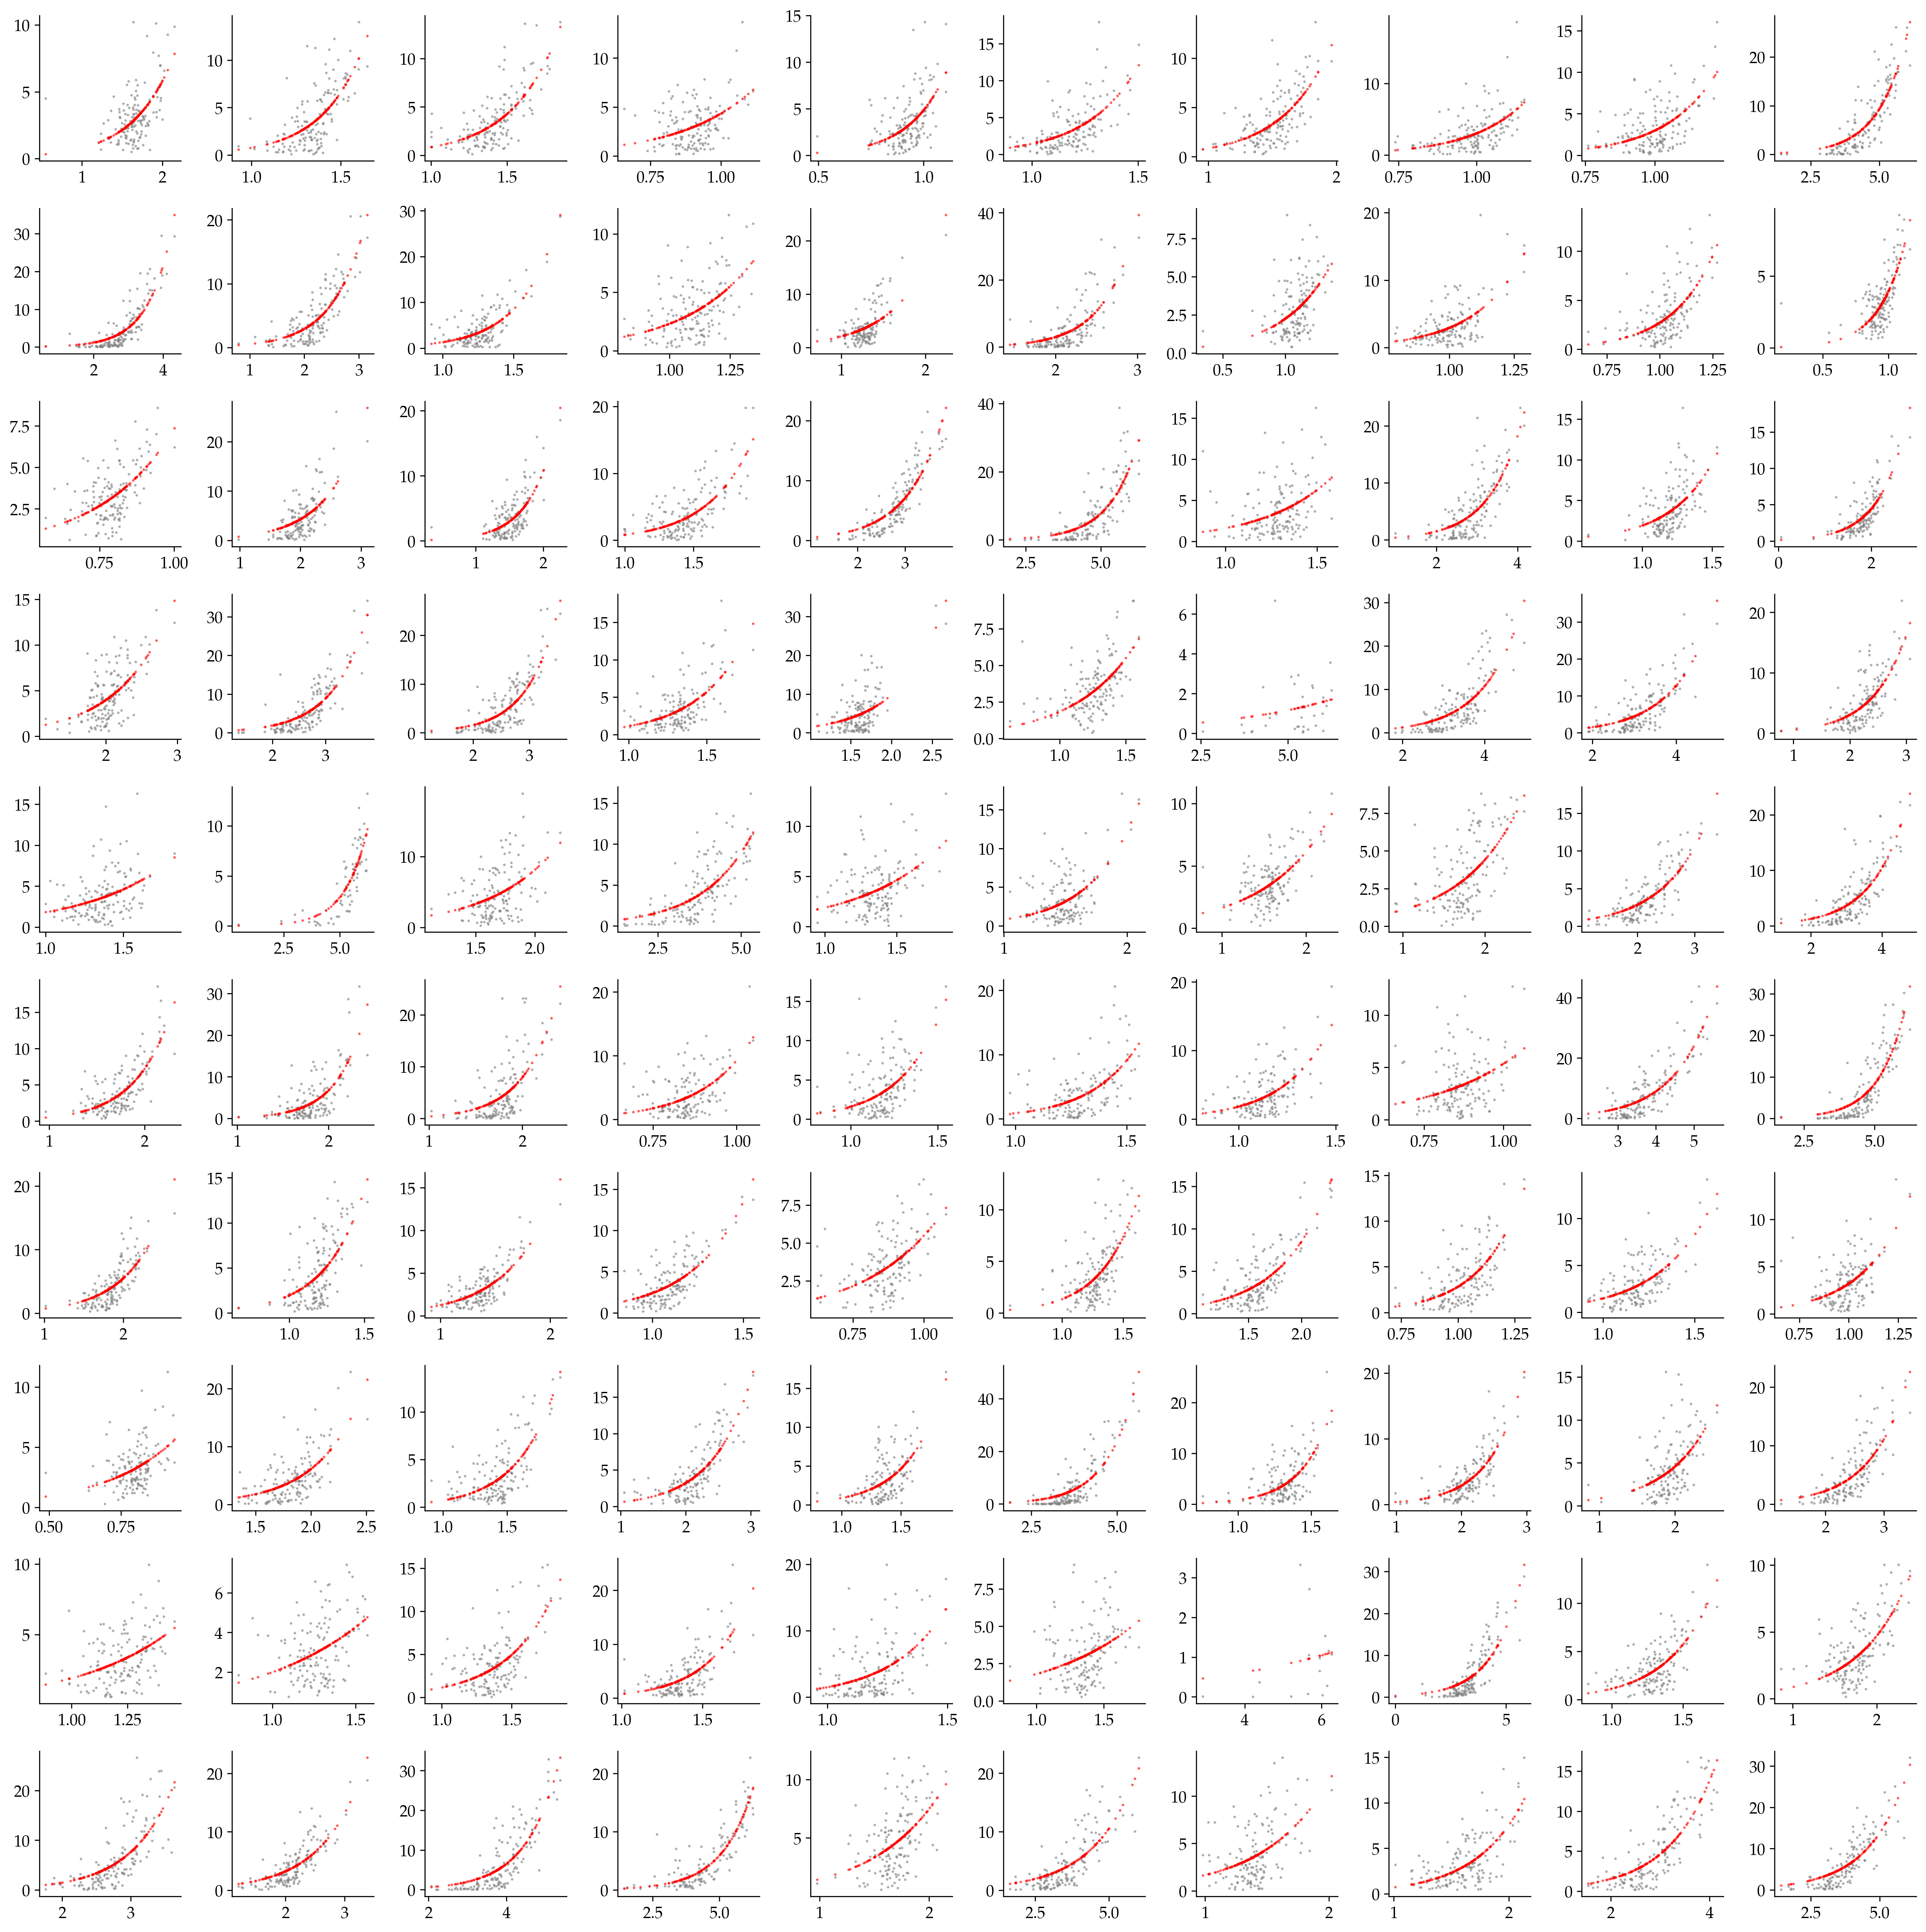

In [38]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for node, node_df in long_df.groupby('node'):
    ax = axes[node]
    ax.scatter(node_df['S_ratio'], node_df['r_E'], s=1, color='grey', alpha=0.5)
    ax.scatter(node_df['S_ratio'], node_df['r_E']-residuals['Log']['r_E~S_ratio'].loc[node_df.index], s=1, color='red', alpha=0.5)
    sns.despine()
fig.tight_layout()

# Figure S18. Effect of model parameters perturbations on $\langle I_i^E \rangle$ and $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$.

Load perturbed simulations data of 40 randomly selected subjects done via `scripts/modeling/run/cuBNM/perturbation/run_perturbation_all.py`:

In [39]:
data40 = data.sample(n=40, random_state=0)

raw_sim_data = {}
for npz_file in glob('./perturbation/*/it1.npz'):
    alt = npz_file.split('/')[2]
    raw_sim_data[alt] = np.load(npz_file, allow_pickle=True)

pert_raw = {}
pert_stats = []
for sub_i, sub in tqdm(enumerate(data40.index)):
    # in all state average calculations the first 30 seconds (10 TRs) are discarded
    orig_S_ratio = (
        raw_sim_data['orig']['sim_states'].reshape(1)[0]["S_E"][sub_i, 10:].mean(axis=0) /
        raw_sim_data['orig']['sim_states'].reshape(1)[0]["S_I"][sub_i, 10:].mean(axis=0)
    )
    pert_raw[sub] = {}
    pert_raw[sub]['orig'] = {
        'S_ratio': orig_S_ratio,
        'I_E': raw_sim_data['orig']["sim_states"].reshape(1)[0]["I_E"][sub_i, 10:].mean(axis=0)
    }
    for alt_param in ["wEE", "wEI", "wIE", "G"]:
        pert_raw[sub][alt_param] = {}
        for ratio in [0.9, 1.1]:
            k = f"{alt_param}_x{ratio}"
            alt_states = raw_sim_data[k]["sim_states"].reshape(1)[0]
            curr_stats = {
                'sub': sub,
                'alt': alt_param,
                'ratio': ratio,
            }
            pert_raw[sub][alt_param][ratio] = {}
            alt_S_ratio = (
                alt_states["S_E"][sub_i, 10:].mean(axis=0) /
                alt_states["S_I"][sub_i, 10:].mean(axis=0)
            )
            curr_stats['S_ratio_T'] = scipy.stats.ttest_rel(
                alt_S_ratio.round(8), 
                orig_S_ratio.round(8)
            ).statistic
            curr_stats['I_E_T'] = scipy.stats.ttest_rel(
                alt_states["I_E"][sub_i, 10:].mean(axis=0).round(8),
                pert_raw[sub]['orig']['I_E'].round(8)
            ).statistic
            pert_stats.append(curr_stats)
            pert_raw[sub][alt_param][ratio]['S_ratio'] = alt_S_ratio
            pert_raw[sub][alt_param][ratio]['I_E'] = alt_states["I_E"][sub_i, 10:].mean(axis=0)
pert_stats = pd.DataFrame(pert_stats)

40it [01:36,  2.42s/it]


In [40]:
pert_stats[['S_ratio_T', 'I_E_T']].abs().describe().round(3)

S_ratio_T    I_E_T
count    320.000  320.000
mean       6.994   21.480
std        2.726    5.383
min        2.287    9.580
25%        5.052   17.630
50%        6.694   21.529
75%        8.319   24.513
max       18.699   38.825

## a. Effect of perturbations on optimal simulation of an example subject

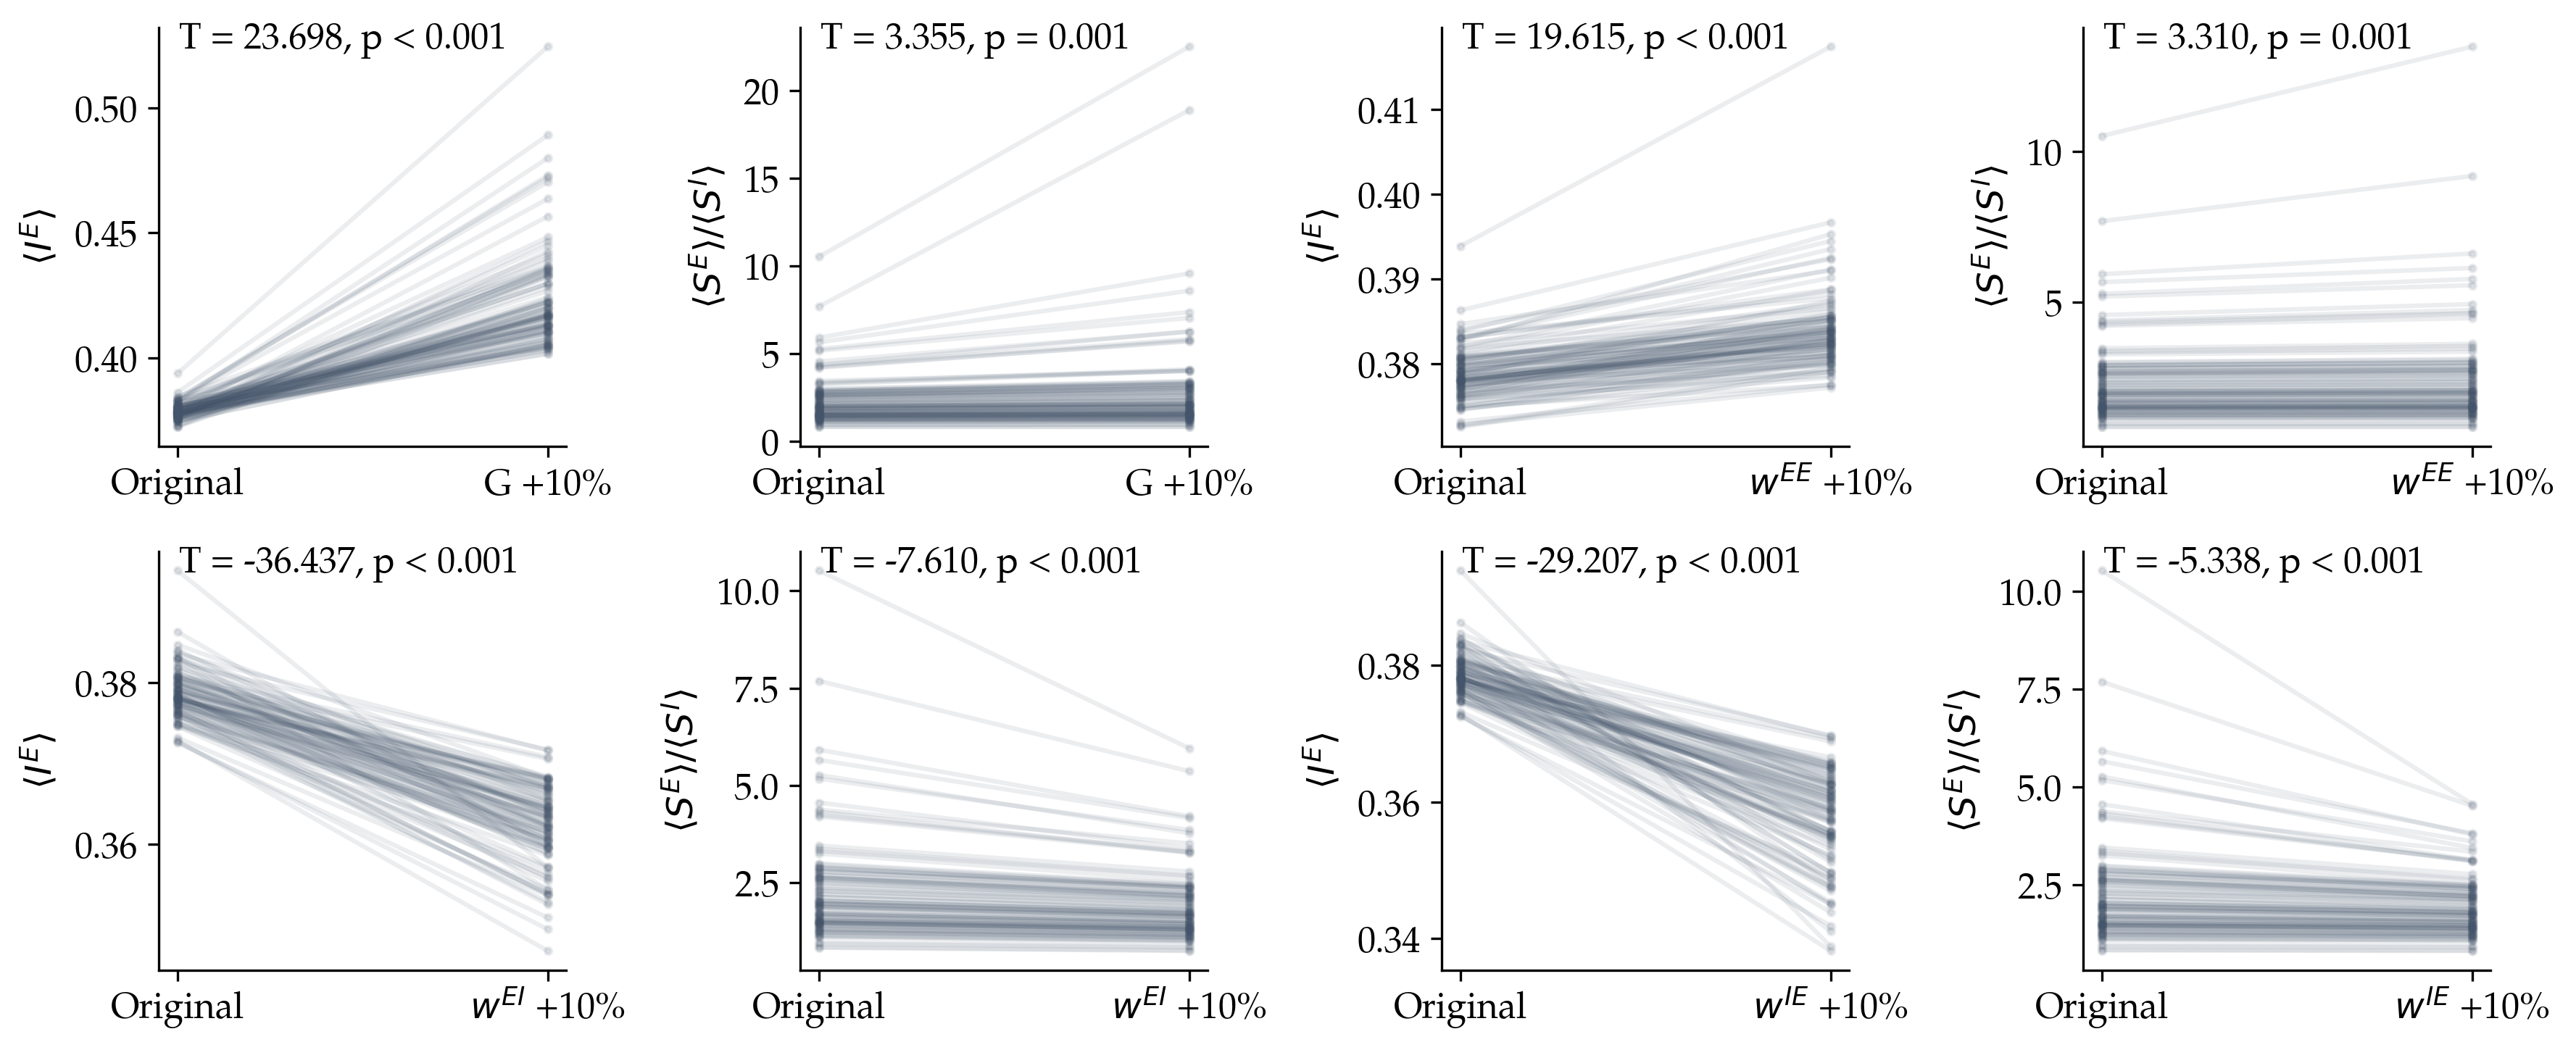

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()
clean_names = {
    'G': 'G',
    'wEE': r'$w^{EE}$',
    'wEI': r'$w^{EI}$',
    'wIE': r'$w^{IE}$',
    'I_E': r'$\langle I^E \rangle$',
    'S_ratio': r'$\langle S^E \rangle/\langle S^I \rangle$'
}

for i, param in enumerate(['G', 'wEE', 'wEI', 'wIE']):
    for k, measure in enumerate(['I_E', 'S_ratio']):
        ax = axes[i*2+k]
        df = pd.DataFrame({
            'Original': pert_raw[sub]['orig'][measure],
            f'{clean_names[param]} +10%': pert_raw[sub][param][1.1][measure],
        })
        long_df = df.unstack().reset_index()
        ax.scatter(
            long_df["level_0"], long_df[0], color=thcolor, s=5, alpha=0.1
        )
        for node in range(100):
            node_df = long_df.loc[long_df["level_1"] == node]
            ax.plot(
                node_df["level_0"],
                node_df[0],
                color=thcolor,
                alpha=0.1,
            )
        t = scipy.stats.ttest_rel(df.iloc[:,1].round(8), df.iloc[:,0].round(8)).statistic
        p = scipy.stats.ttest_rel(df.iloc[:,1].round(8), df.iloc[:,0].round(8)).pvalue
        text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
        text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
        text = f'T = {t:.3f}, '
        if p < 0.001:
            text+= 'p < 0.001'
        else:
            text+= f'p = {p:.3f}'
        ax.text(text_x, text_y, text, color="black", multialignment="left")
        ax.set_ylabel(clean_names[measure])
        sns.despine()
fig.tight_layout()

## b. Distribution of perturbtaion effect paired T statistics across all 40 subjects

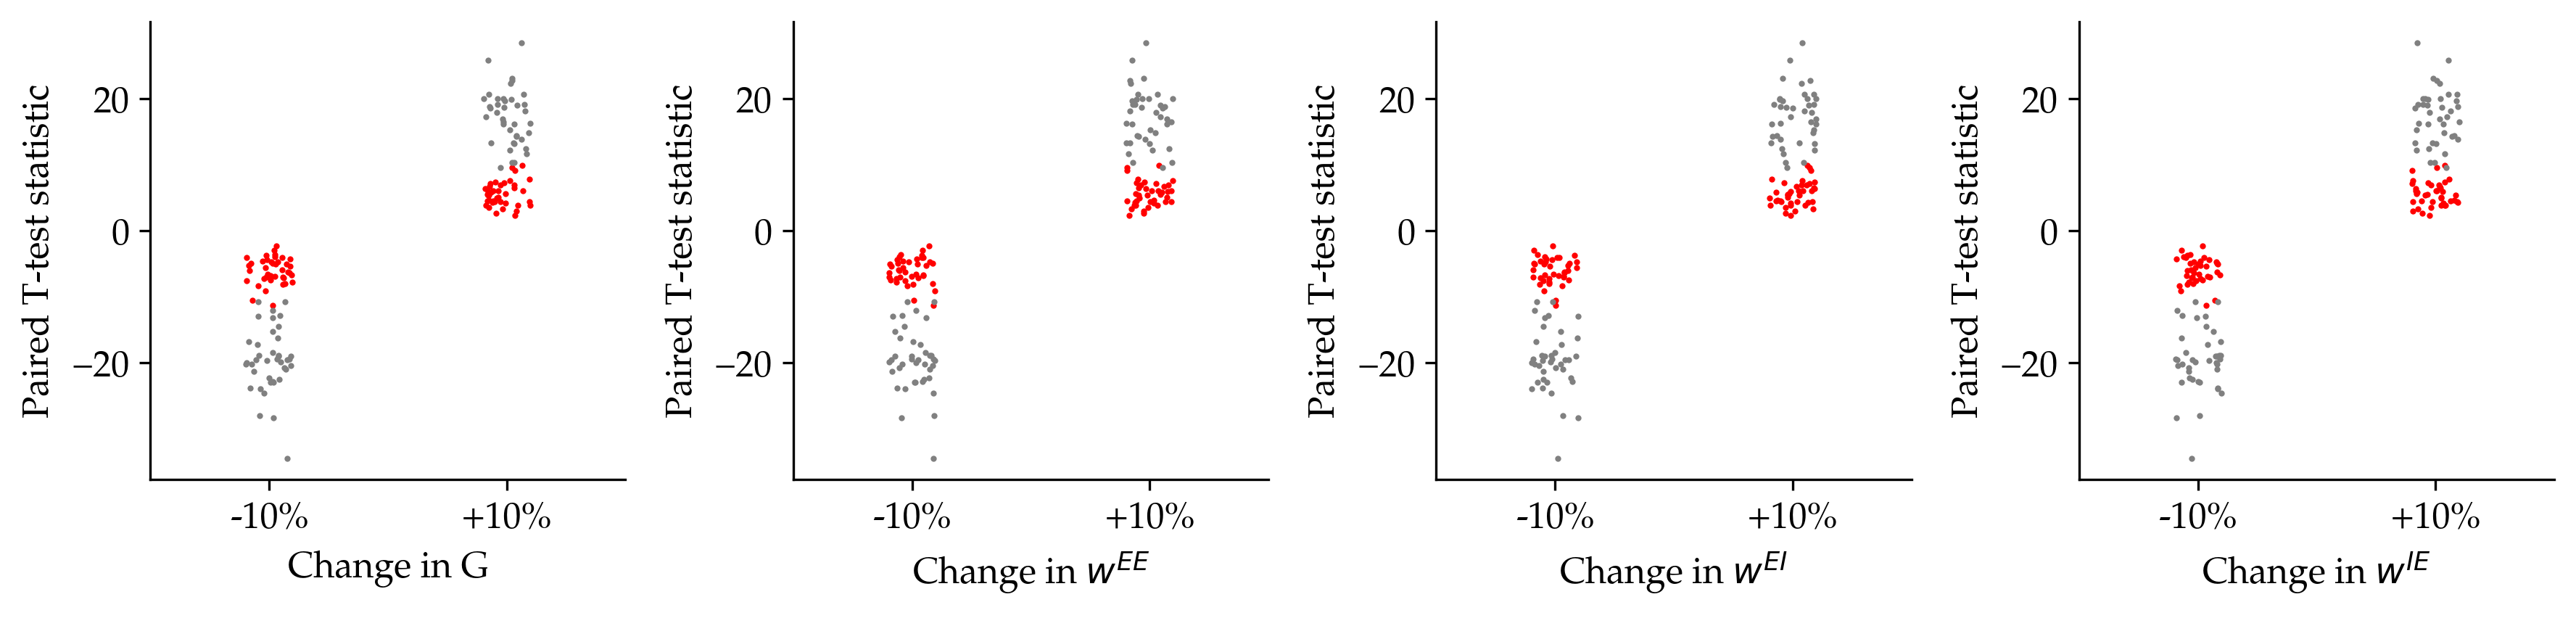

In [42]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.flatten()
for i, param in enumerate(['G', 'wEE', 'wEI', 'wIE']):
    ax = axes[i]
    curr_data = pert_stats.loc[(pert_stats['alt']=='wEE') & (pert_stats['ratio'].isin([0.9, 1.1]))]
    sns.stripplot(data=curr_data, y='S_ratio_T', x='ratio', ax=ax, color='red', size=2)
    sns.stripplot(data=curr_data, y='I_E_T', x='ratio', ax=ax, color='grey', size=2)
    ax.set_xlabel(f'Change in {clean_names[param]}')
    ax.set_xticklabels(['-10%', '+10%'])
    ax.set_ylabel('Paired T-test statistic')
    sns.despine()
fig.tight_layout()

(0.0, 1.0, 0.0, 1.0)

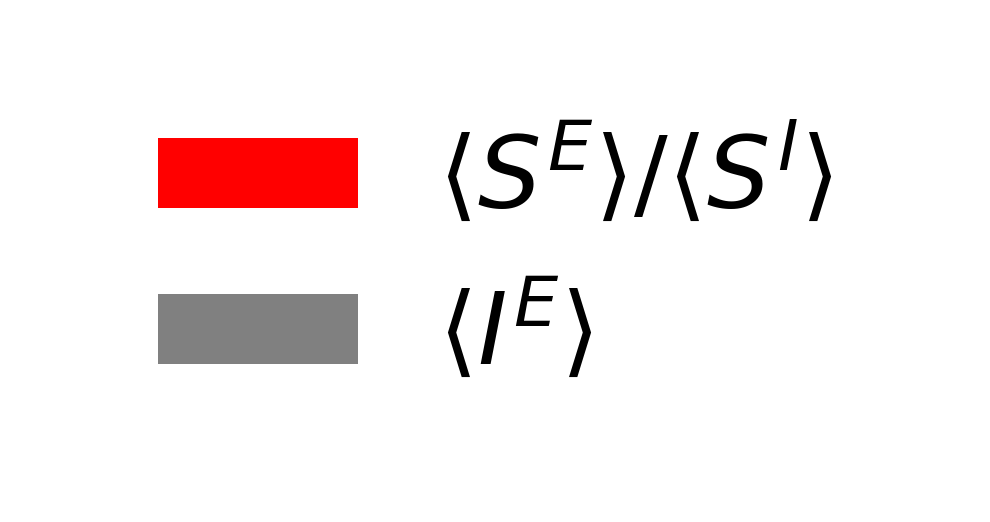

In [43]:
from matplotlib.patches import Patch
colors = {clean_names['S_ratio']: 'red', clean_names['I_E']: 'grey'}
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")